## Импорты

In [1]:
import importlib
import json
import os
import sys
import warnings

import matplotlib.pyplot as plt

from collections import Counter

import numpy as np
import tensorflow as tf

from tensorflow.keras import Model, layers, optimizers, losses
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

from typing import List, Dict, Any, Tuple
from music21 import chord, note, instrument, environment

import torch
from torch.utils.data import Dataset, DataLoader

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

# Всё, что выводит CUDA / XLA, будет записано в файл
sys.stderr = open("xla_warnings.log", "w")



sys.path.append('src')

# в режиме редактирования сбрасуем кэшь иначе не видно изменений
for module in [
    "utils.music21_utils",
    "utils.data_utils",
    "utils.dataset_utils",
    "utils.tokenizer_utils",
    "utils.model_utils",
    "utils.__init__"
    
]:
    imported_module = importlib.import_module(module)
    importlib.reload(imported_module)


from utils.__init__ import (
    compute_global_stats,
    denormalize_sequence_global,
    align_timelines, 
    save_multi_track_midi,
    get_all_midis,
    midi_to_notes,
    Music21Tokenizer,
    MusicTransformerED,
    MIDIDataset,
    collate_chunks,
    TripleLoss,
    detect_instruments_in_midi,
    extract_sample,
    generate_full_autoregressive,
    try_denorm
)


# настраиваем окружение в соответствии с документацией
us = environment.UserSettings()
environment.set('midiPath', '/usr/bin/timidity')
us['musescoreDirectPNGPath'] = '/usr/bin/mscore3'
us['directoryScratch'] = '/tmp'

2025-12-01 22:33:14.512180: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764617594.525032  470757 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764617594.529198  470757 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1764617594.539369  470757 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764617594.539382  470757 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764617594.539384  470757 computation_placer.cc:177] computation placer alr

## Загрузка midi файлов

In [2]:
# Считаем все файлы
all_pretrain_midis = get_all_midis("../dataset")

# Считаем только Chopin
chopin_midis = get_all_midis("../dataset/Chopin")

## Собираем все инструменты

In [3]:
instruments = []
for score in all_pretrain_midis:
    instruments.extend(detect_instruments_in_midi(score))
global_instruments = set(instruments)

## Собираем сэмплы со всеми инструментами если нет то пропуск

In [4]:
samples = []
for score in all_pretrain_midis[1:]:
    sample = extract_sample(score, global_instruments)
    samples.append(sample)

## Инициализируем токенизатор

In [5]:
tokenizer = Music21Tokenizer()

## Инициализируем данные

In [6]:
input_instruments = ['Piaro right', 'Piano left2']
target_instrument = 'Piano'

pitch_offset = 21
rare_note = None
SEQ_LEN = 32
ENC_LEN = 256
DEC_LEN = 128

device = torch.device("cpu")

## Готовим датасет

In [7]:
## фильтруем где есть piano
filtered = [s for s in samples if len(s.get(target_instrument, []))>0]

In [8]:
## 2. Глобальная статистика

In [9]:
## собираем все ноты
all_notes = []
for midi in all_pretrain_midis:
    all_notes.extend(midi_to_notes(midi))

Средняя повторяемость ноты: 6199.827586206897
Наиболее часто встречаемые ноты: 18356 раз
Наиболее редкие ноты: 2 раз
Общее число нот, которые повторяются менее 100 раз: 9


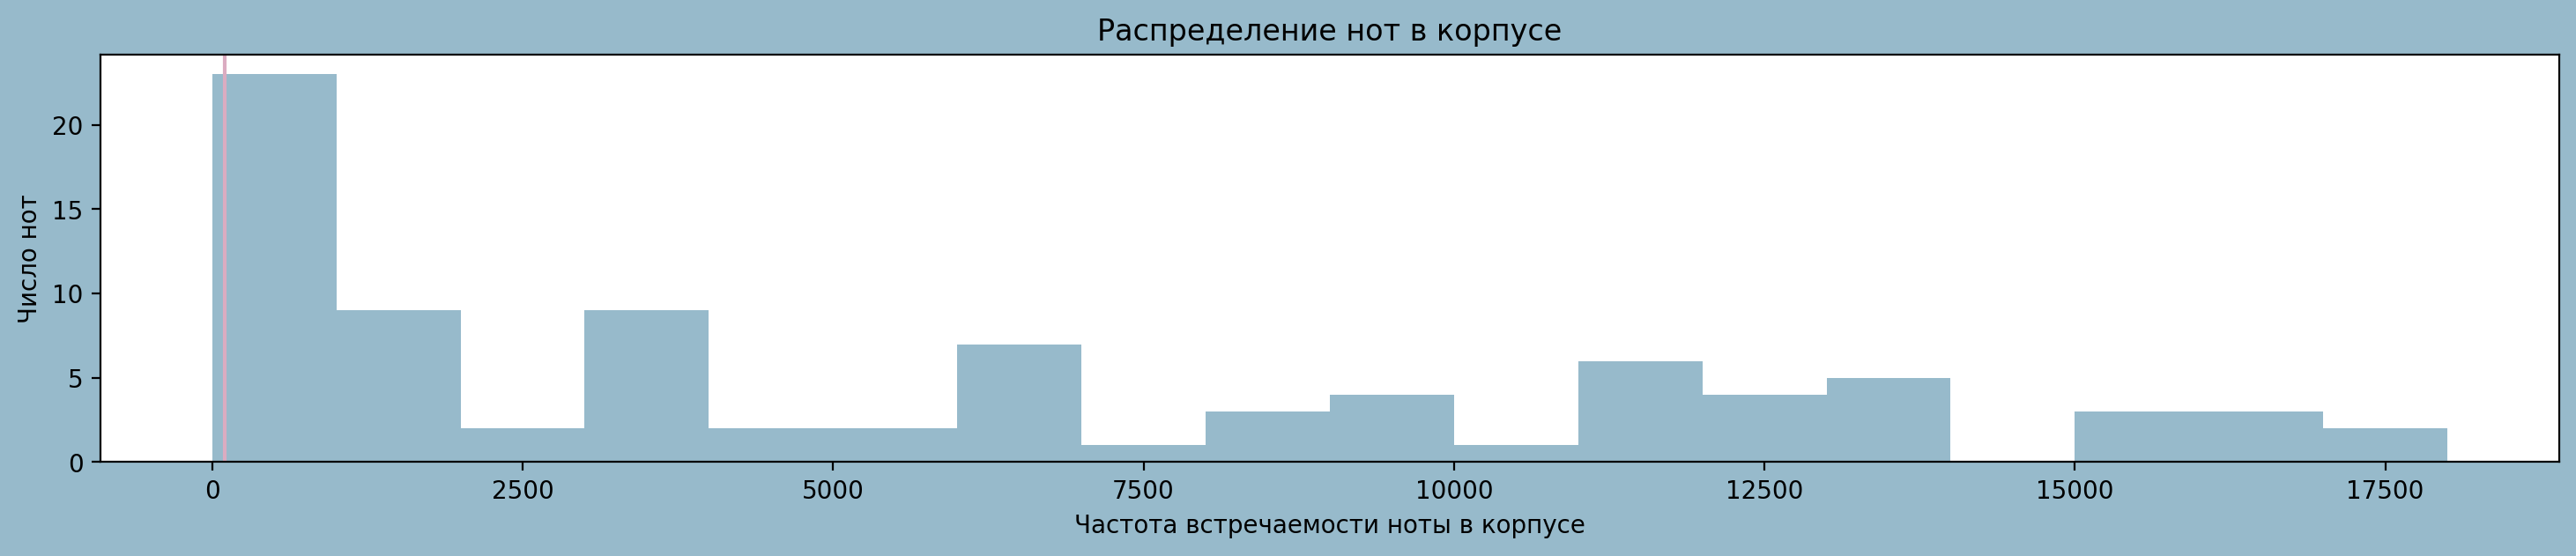

Длина корпуса после исключения редких нот: 539117
Global stats: {'pitch_min': 21.0, 'pitch_max': 105.0, 'step_max': 2.0, 'dur_max': 3.0}


In [10]:
### Удаляем мало повторяемые ноты

count_num = Counter([note['pitch'] for note in all_notes])

# Ключ в словаре - имена нот
# Значение в словаре - их количество

Notes = list(count_num.keys())
Recurrence = list(count_num.values())

# Средняя частота встречаемости нот в корпусе
def Average(rec):
    return sum(rec) / len(rec)

print('Средняя повторяемость ноты:', Average(Recurrence))
print('Наиболее часто встречаемые ноты:', max(Recurrence), 'раз')
print('Наиболее редкие ноты:', min(Recurrence), 'раз')

# Будем избавляться от нот, которые встретились менее 100 раз.

# Получение списка редких нот
rare_note = []
for index, (key, value) in enumerate(count_num.items()):
    if value < 100:
        m =  key
        rare_note.append(m)

print("Общее число нот, которые повторяются менее 100 раз:", len(rare_note))

plt.figure(figsize=(18, 3), facecolor='#97BACB')
bins = np.arange(0,(max(Recurrence)), 1000)
plt.hist(Recurrence, bins=bins, color='#97BACB')
plt.axvline(x=100, color='#DBACC1') # отсечка по встречаемости в 100 раз
plt.title('Распределение нот в корпусе')
plt.xlabel('Частота встречаемости ноты в корпусе')
plt.ylabel('Число нот')
plt.show()

# **Удаление редких нот**

for element in all_notes:
    if element['pitch'] in rare_note:
        all_notes.remove(element)

print("Длина корпуса после исключения редких нот:", len(all_notes))

### Составляем глобальную статику

stats = compute_global_stats(all_notes)
print("Global stats:", stats)

pitch_offset = int(stats["pitch_min"])  # обязательный
step_max = stats["step_max"]
dur_max = stats["dur_max"]

In [11]:
## готовим датасет для предобученной модели
# -------------------------
# 3) DataLoader
# -------------------------
dataset = MIDIDataset(filtered, tokenizer, stats, pitch_offset,
                      target_instrument='Piano',
                      input_instruments=input_instruments, L_enc=100, L_dec=32)

loader = DataLoader(dataset,
                    batch_size=16,   # batch_size по "сэмплам" = количество items из dataset
                    shuffle=True,
                    collate_fn=collate_chunks,
                    drop_last=True)

In [ ]:
## 7. Обучение предобученной модели
# -------------------------
# -------------------------
model = MusicTransformerED(pitch_vocab=128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = TripleLoss(pitch_vocab=128)

In [27]:
# 4) Training loop

for epoch in range(10):
    total_loss = 0
    for batch in loader:
        enc = batch['enc_in'].to(device)       # (B, L_enc, F)
        dec = batch['dec_in'].to(device)
        pitch_t = batch['pitch_targets'].to(device)
        step_t  = batch['step_targets'].to(device)
        dur_t   = batch['dur_targets'].to(device)
    
        enc_mask = (enc.sum(dim=-1) == 0)     # (B, L_enc)
        dec_mask = (dec.sum(dim=-1) == 0)     # (B, L_dec)
    
        optimizer.zero_grad()
        pitch_logits, step_out, dur_out = model(enc, dec, enc_mask, dec_mask)
    
        loss, _ = criterion(pitch_logits, step_out, dur_out, pitch_t, step_t, dur_t)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1} loss={total_loss/len(loader):.4f}")


# -------------------------
# 5) Save checkpoint
# -------------------------
torch.save(model.state_dict(), "pretrain_checkpoint.pt")


Epoch 1 loss=0.0100
Epoch 2 loss=0.0104
Epoch 3 loss=0.0104
Epoch 4 loss=0.0097
Epoch 5 loss=0.0094
Epoch 6 loss=0.0092
Epoch 7 loss=0.0095
Epoch 8 loss=0.0092
Epoch 9 loss=0.0092
Epoch 10 loss=0.0092


In [28]:
## подготавливем данные для Fine tuning


### 3. Подготовка данных
samples_chopin = []
for score in chopin_midis:
    sample = extract_sample(score, global_instruments)
    samples_chopin.append(sample)
    
filtered_chopin = [s for s in samples_chopin if len(s.get(target_instrument, []))>0]

# -------------------------
# 3) DataLoader
# -------------------------
chopin_dataset = MIDIDataset(filtered_chopin, tokenizer, stats, pitch_offset,
                      target_instrument='Piano',
                      input_instruments=input_instruments, L_enc=100, L_dec=32)

chopin_loader = DataLoader(chopin_dataset,
                    batch_size=16,   # batch_size по "сэмплам" = количество items из dataset
                    shuffle=True,
                    collate_fn=collate_chunks,
                    drop_last=True)

In [29]:
## обучаем Fine tuning модель
### загружаем модель
# -------------------------
# 6) Fine-tuning
# -------------------------
model.load_state_dict(torch.load("pretrain_checkpoint.pt"))
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

In [30]:
### обучение

finetune_epochs = 10

for epoch in range(finetune_epochs):
    total_loss = 0
    for batch in chopin_loader:
        enc = batch['enc_in'].to(device)
        dec = batch['dec_in'].to(device)
        pitch_t = batch['pitch_targets'].to(device)
        step_t  = batch['step_targets'].to(device)
        dur_t   = batch['dur_targets'].to(device)

        # Создаём маски
        enc_mask = (enc.sum(dim=-1) == 0)
        dec_mask = (dec.sum(dim=-1) == 0)

        optimizer.zero_grad()
        pitch_logits, step_out, dur_out = model(enc, dec, enc_mask, dec_mask)
        loss, _ = criterion(pitch_logits, step_out, dur_out, pitch_t, step_t, dur_t)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1} loss={total_loss/len(chopin_loader):.4f}")


# -------------------------
# 5) Save checkpoint
# -------------------------
torch.save(model.state_dict(), "chopin_checkpoint.pt")

Epoch 1 loss=0.0096
Epoch 2 loss=0.0096
Epoch 3 loss=0.0087
Epoch 4 loss=0.0085
Epoch 5 loss=0.0083
Epoch 6 loss=0.0087
Epoch 7 loss=0.0086
Epoch 8 loss=0.0082
Epoch 9 loss=0.0085
Epoch 10 loss=0.0082


In [31]:
## готовим данные для генерации
# 2) Выбрать примеры для генерации
# Вариант A: взять батч из dataloader (chopin_loader). Если вы хотите конкретный sample, замените это.
batch = next(iter(chopin_loader))
# ожидаемые ключи: 'enc_in' и/или 'enc_melody'/'enc_bass' (если есть)
enc_in_batch = batch.get('enc_in', None)      # (B, L_enc, F) torch.Tensor
enc_mel_batch = batch.get('enc_melody', None) # optional
enc_bass_batch = batch.get('enc_bass', None)  # optional

# Берём первый пример в батче
if enc_mel_batch is not None and enc_bass_batch is not None:
    enc_mel = enc_mel_batch[0:1].cpu().numpy()   # (1, L_enc, F)
    enc_bass = enc_bass_batch[0:1].cpu().numpy()
    enc_input_for_model = enc_in_batch[0:1].to(device) if enc_in_batch is not None else enc_mel_batch[0:1].to(device)
else:
    # Нет отдельных мелодии/басса — используем enc_in и передаём пустой второй трек
    enc_input_for_model = enc_in_batch[0:1].to(device)   # (1, L_enc, F)
    # Для выравнивания нам нужны денормализованные энкодерные последовательности.
    # Попробуем сделать денормализованный enc_seq из enc_in (если enc_in содержит (pitch,step,dur) трек)
    enc_seq_np = enc_input_for_model.cpu().numpy().squeeze(0)  # (L_enc, F)
    # Если enc_seq_np имеет 3 колонки -> считаем это как трек
    if enc_seq_np.shape[-1] == 3:
        enc_mel = enc_seq_np.copy()   # treat as single track
        enc_bass = np.zeros((0,3))
    else:
        # Невозможно однозначно восстановить enc_mel/enc_bass — вернем пустой bass
        enc_mel = enc_seq_np[..., :3] if enc_seq_np.shape[-1] >= 3 else enc_seq_np
        enc_bass = np.zeros((0,3))

In [32]:
## Генерация
model = MusicTransformerED(pitch_vocab=128).to(device)
model.load_state_dict(torch.load("chopin_checkpoint.pt"))
# 3) Seed и генерация (нормализованные значения, как при тренировке)
seed_dec = np.zeros((1, 1, 3), dtype=np.float32)

generated_norm = generate_full_autoregressive(
    model,
    enc_input=enc_input_for_model.cpu().numpy(),   # функция сама переводит в torch.tensor
    seed_dec=seed_dec,
    length=16,
    pitch_temp=0.9,
    cont_temp=0.02,
    cont_scale={'step': stats['step_max'], 'dur': stats['dur_max']},
    sampling_mode='stochastic',
    stats=stats,
    device=device
)  

In [33]:
# 4) Денормализация
# denormalize_sequence_global должен принимать (1, T, 3) или (T,3) — используем (1, T, 3)
generated_denorm = denormalize_sequence_global(generated_norm, stats)  # формат (1, T, 3)

In [34]:
# приведение к форме (T,3)
if generated_denorm.ndim == 3:
    gen_seq = generated_denorm[0, 1:, :]  # исключаем seed (первый элемент)
else:
    gen_seq = generated_denorm[1:, :]

In [36]:
enc_mel_den = try_denorm(enc_mel, stats)
enc_bass_den = try_denorm(enc_bass, stats)

In [37]:
# 6) Выравнивание таймлайнов и сборка финального MIDI
enc1_aligned, enc2_aligned, gen_aligned = align_timelines(enc_mel_den, enc_bass_den, gen_seq, method='clip')

In [38]:
out_path = "generated_from_chopin_sample.mid"
saved_fp = save_multi_track_midi(enc1_aligned, enc2_aligned, gen_aligned, fp=out_path,
                                 instr1="Piano", instr2="Piano", instr_gen="Piano")

print("Saved MIDI to:", saved_fp)

# 7) Информационный вывод
print("Generated notes (first 10):")
print("pitch:", gen_seq[:10,0])
print("onset steps (cumulative):", gen_seq[:10,1])
print("durations:", gen_seq[:10,2])


Saved MIDI to: generated_from_chopin_sample.mid
Generated notes (first 10):
pitch: [ 95.  14.  14. 121.  48.  72.  20.  34.   0.  33.]
onset steps (cumulative): [3.0196555e-02 3.0196555e-02 1.2963942e-01 2.1555293e-01 6.9904041e-01
 1.7052062e+00 3.9559743e+00 9.0349627e+00 2.0792099e+01 4.4482872e+01]
durations: [ 0.8902046  2.0298917  5.152032  10.29976   13.297331  13.893312
 15.180361  15.356667  13.386587   8.241862 ]


## Вывод